In [18]:
# Import necessary libraries
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

In [2]:
import os

os.chdir('..') # Change to parent directory
cwd = os.getcwd() # Get current working directory
print(cwd)

C:\Users\templ\OneDrive\Desktop\AI\Hackathon\Amazon


In [3]:
# Read the dataset using Dask
dataset = pd.read_csv('dataset/ProductsumySummary.csv', on_bad_lines='skip', encoding='utf-8', engine='python')
# dataset =  dataset.sample(n=20000)

In [4]:
dataset.columns


Index(['PRODUCT_ID', 'product_summary', 'PRODUCT_TYPE_ID', 'PRODUCT_LENGTH'], dtype='object')

In [5]:
dataset

,PRODUCT_ID,product_summary,PRODUCT_TYPE_ID,PRODUCT_LENGTH
0,1796785,arya farm health drink protein energi chocol d...,0,984.251967
1,2988520,wild forest honey 100 natur wild forest honey 1kg,0,787.401574
2,2264065,amwel barnyard millet flour samak atta pack tw...,0,590.551180
3,259987,mineria en andalucia historia de la mina de hu...,0,744.093000
4,1388680,pur attitud relax rest renew beauti booster di...,0,157.000000
...,...,...,...,...
301726,839691,util basket accentu earthi color rustic overto...,13416,1200.000000
301727,1845315,road trip light travel hat box uniqu featur ma...,13416,1600.000000
301728,1614426,slpr natur water hyacinth storag basket bin ha...,13416,1420.000000
301729,1913923,begal 6-pack plastic storag box storag bin bla...,13416,1480.000000


In [7]:
df = dataset

In [13]:
# Drop rows containing NaN values in product_summary column
df = df.dropna(subset=['product_summary'])

# Apply tfidf vectorizer to product_summary column
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(df['product_summary'])

# Separate the predictor variables (X_tfidf) from the target variable (Y) and apply StandardScaler
Y = df['PRODUCT_LENGTH']
scaler = StandardScaler()
Y_scaled = scaler.fit_transform(Y.to_numpy().reshape(-1, 1))

# Include PRODUCT_ID and PRODUCT_TYPE_ID as additional predictor variables
X = df[['PRODUCT_ID', 'PRODUCT_TYPE_ID']].to_numpy()

In [15]:
# Perform truncated SVD on the combined predictor variables
svd = TruncatedSVD(n_components=50, random_state=42)
X_svd = svd.fit_transform(X_tfidf)

# Combine the SVD features with the additional predictor variables
X_combined = pd.concat([pd.DataFrame(X), pd.DataFrame(X_svd)], axis=1)

# Apply PCA to the combined predictor variables
pca = PCA()
X_pca = pca.fit_transform(X_combined)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y_scaled, test_size=0.2, random_state=42)

In [19]:
X_pca

array([[ 2.97865819e+05, -4.35288746e+03,  1.82480749e-04, ...,
        -1.78366817e-02,  2.62091977e-02,  5.20881831e-02],
       [ 1.48960003e+06, -5.72055702e+03, -1.58817846e-02, ...,
         1.12339844e-03, -4.08947337e-02, -1.56499397e-02],
       [ 7.65145512e+05, -4.88915151e+03, -6.18801345e-03, ...,
        -3.78248916e-03,  4.94790036e-03,  2.09231478e-02],
       ...,
       [ 1.15522336e+05,  9.27238416e+03, -1.05256764e-01, ...,
        -5.59324977e-03, -5.99526167e-04,  1.94395191e-02],
       [ 4.15019139e+05,  8.92867274e+03, -8.66440767e-02, ...,
        -5.08612933e-03,  5.54980689e-02,  4.87487076e-02],
       [-1.30290497e+05,  9.55848627e+03, -1.16676902e-01, ...,
         2.02227712e-02,  7.11821807e-03,  3.08074172e-02]])

In [21]:
# Define the parameter grid to search
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

In [42]:
# Train the decision tree model using GridSearchCV to find the best hyperparameters
model = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid,
    cv=5,
    n_jobs=-1
)
model.fit(X_train, Y_train)

# Make predictions on the test set using the best model
Y_pred_scaled = model.predict(X_test)

# Inverse transform the scaled predictions to get the actual predictions
# Y_pred = scaler.inverse_transform(Y_pred_scaled)


In [25]:
# Inverse transform the scaled predictions to get the actual predictions
Y_pred = scaler.inverse_transform(Y_pred_scaled.reshape(-1, 1))


In [26]:
# Calculate the evaluation metric score
score = max(0, 100*(1-mean_absolute_percentage_error(Y_test, Y_pred)))

# Print the best hyperparameters and the score
print("Best Hyperparameters:", model.best_params_)
print("Score:", score)

Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10}
Score: 0


In [28]:
import pickle
# Save the KMeans model
with open('Decision tree.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('treeSC.pkl', 'wb') as f:
    pickle.dump(scaler, f)    
    
# Save the TF-IDF vectorizers
with open('DTtfidf.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

with open('pca.pkl', 'wb') as f:
    pickle.dump(pca, f)

In [40]:
import matplotlib.pyplot as plt
import numpy as np

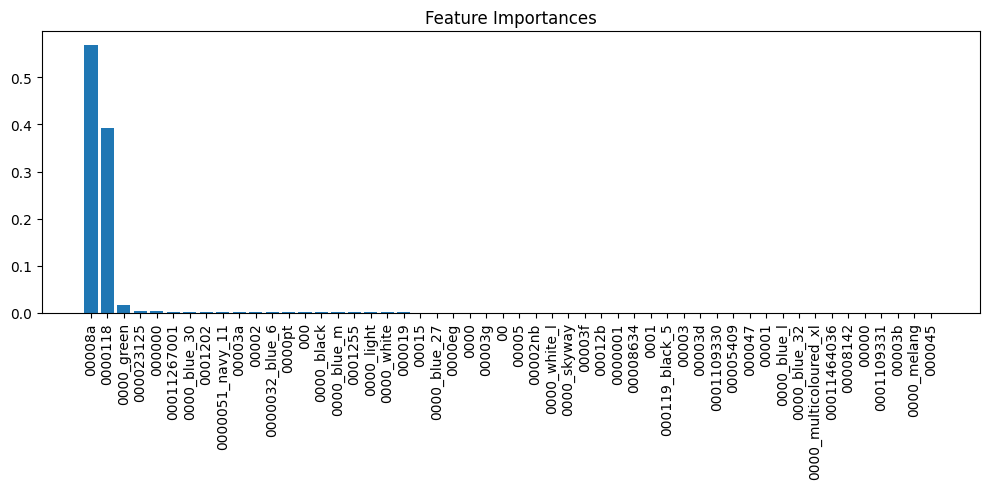

In [41]:
plt.figure(figsize=(10, 5))
plt.title('Feature Importances')
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices])
plt.xticks(range(len(feature_importances)), np.array(feature_names)[sorted_indices], rotation=90)
plt.tight_layout()
plt.savefig('feature_importances.jpg')

In [ ]:
plt.savefig('myplot.jpg', dpi=300, bbox_inches='tight')